In [276]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

#%pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
sns.reset_orig()
matplotlib.rcParams.update({'font.size': 12})

### 1. Accuracy - Loss - Free Parameters

In [279]:
res = loadfile(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", model_save_dir = "./files")

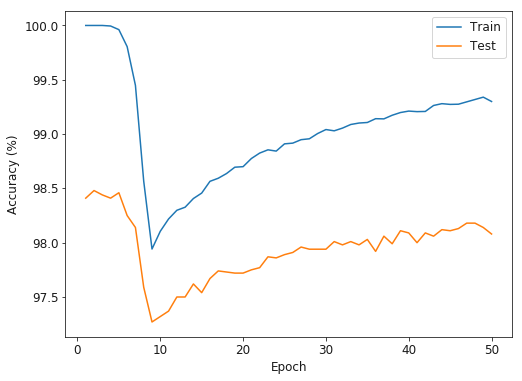

In [280]:
plt.figure(figsize=(8,6))
train = plt.plot(res['epochs'], res['train_acc'], label = "Train")
test = plt.plot(res['epochs'], res['test_acc'], label = "Test")
plt.legend(ncol=1, fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.savefig('figs/swsacc.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

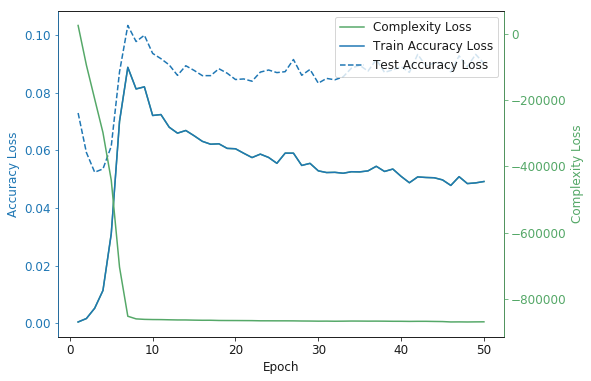

In [316]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax2 = ax1.twinx()
ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Complexity Loss", color = 'g')
p = ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Train Accuracy Loss")
color = p[0].get_color()
ax1.plot(res['epochs'], res['test_loss'], label = "Test Accuracy Loss", linestyle = "--", color = color)
ax1.legend(loc=1)
ax2.plot(res['epochs'], res['complexity_loss'], label = "Complexity", color = 'g')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy Loss', color=color)
ax2.set_ylabel('Complexity Loss', color='g')
ax2.spines['left'].set_color(color)
ax2.spines['right'].set_color('g')
ax1.tick_params(axis='y', colors=color)
ax2.tick_params(axis='y', colors='g')
plt.savefig('figs/swsloss.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

In [282]:
res = loadfile(100, 1.0, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files")

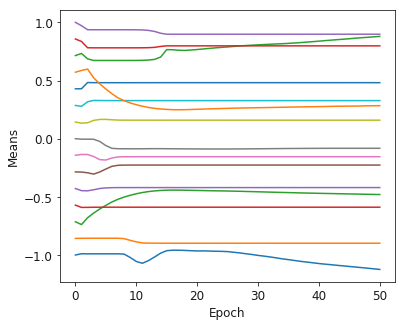

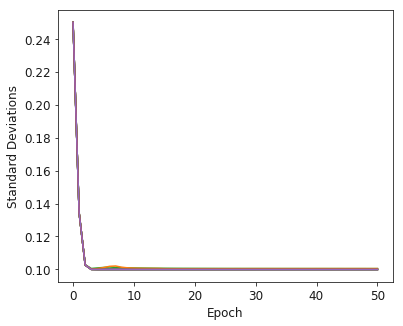

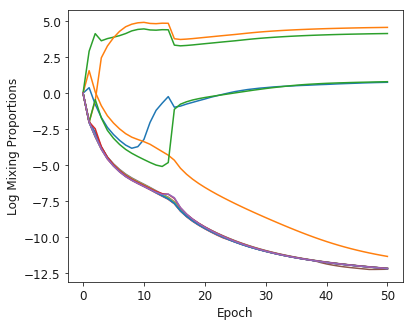

In [283]:
plt.figure(figsize=(6,5))
plt.plot([0] + res['epochs'], res['gmp_means'])
plt.xlabel('Epoch')
plt.ylabel('Means')
plt.savefig('figs/swsmeans.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,5))
plt.plot([0] + res['epochs'], res['gmp_stddev'][:,1:]) #w/out 0 means
plt.xlabel('Epoch')
plt.ylabel('Standard Deviations')
plt.savefig('figs/swsstd.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,5))
plt.plot([0] + res['epochs'], np.log(res['gmp_mixprop'][:,:]))
plt.xlabel('Epoch')
plt.ylabel('Log Mixing Proportions')
plt.savefig('figs/swsmixprop.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

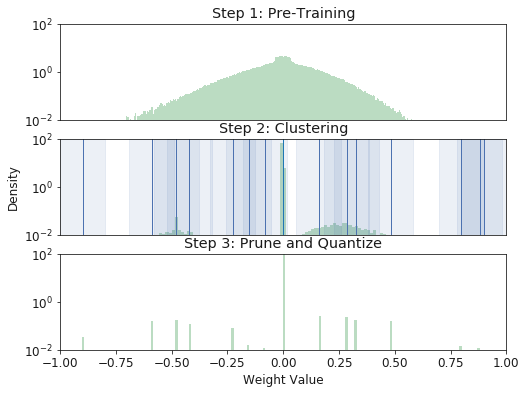

In [284]:
plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
plt.title("Step 1: Pre-Training")
weights = stack_weights(res['init_weights'])
sns.distplot(weights, kde=False, color="g",bins=400,norm_hist=True, hist_kws={'log':True})
  
plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])


ax2 = plt.subplot(312)
plt.title("Step 2: Clustering")
plt.ylabel("Density")
weights = stack_weights(res['final_weights'])
sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})

plt.axvline(0, linewidth = 1)
std_dev0 = res['gmp_stddev'][-1][0]
plt.axvspan(xmin=-std_dev0, xmax=std_dev0, alpha=0.1)
for mean, std_dev in zip(res['gmp_means'][-1], res['gmp_stddev'][-1][1:]):
    plt.axvline(mean, linewidth = 1, color = 'b')
    plt.axvspan(xmin=mean - std_dev, xmax=mean + std_dev, alpha=0.1, color = 'b')
    

plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])


ax3 = plt.subplot(313)
plt.title("Step 3: Prune and Quantize")
weights = stack_weights(res['prune_weights'])
sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})

plt.xlabel("Weight Value")
plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])

plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.xaxis.set_ticks_position('none') 
ax2.xaxis.set_ticks_position('none') 
ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)
plt.savefig('figs/swspipeline.eps', format='eps', dpi=500, bbox_inches='tight')
plt.show()



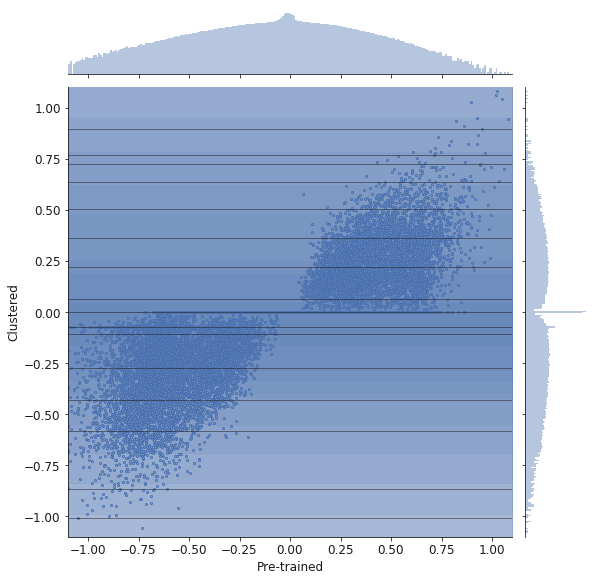

In [702]:
weights_P = stack_weights(res['init_weights'])
weights_C = stack_weights(res['final_weights'])
#weights_P = res['init_weights'][layer]
#weights_C = res['final_weights'][layer]
mu_C = np.concatenate([np.zeros(1), res['gmp_means'][-1]])
std_C = res['gmp_stddev'][-1]
lim = 1.1
#I = np.random.permutation(len(weights_P))
f = sns.jointplot(weights_P, weights_C, size=8, kind="scatter", color="w", stat_func=None, edgecolor='b', marker='o', joint_kws={"s": 4}, marginal_kws=dict(color="b", bins=400), ratio=6)
f.ax_joint.hlines(mu_C, -lim, lim, lw=0.5)

for k in range(len(mu_C)):
    f.ax_joint.fill_between(np.linspace(-lim, lim, 10), mu_C[k] - std_C[k], mu_C[k] + std_C[k], color='b', alpha=0.1)

f.ax_marg_y.set_xscale("log")
f.ax_marg_x.set_yscale("log")
f.set_axis_labels("Pre-trained", "Clustered")

f.ax_marg_x.set_xlim(-lim, lim)
f.ax_marg_y.set_ylim(-lim, lim)
f.ax_marg_x.set_rasterized(True)
f.ax_marg_y.set_rasterized(True)
f.ax_joint.set_rasterized(True)
plt.savefig('figs/swsmap.eps', format='eps', dpi=500, bbox_inches='tight')
plt.show()

### 2. Variance on Gamma Priors

In [286]:
exp = pd.DataFrame(columns = ["var", "zvar", "acc", "sp"])
idx=0
start_processing = False
#start from 10, 1000
for var in [0.1, 1, 10, 100, 1000]:
    for zvar in [0.1, 1, 10, 100, 1000, 10000]:
        fn_text = "_var_{}_zvar_{}".format(var,zvar)
        res = loadfile(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", model_save_dir = "./files", fn=fn_text)
        exp.loc[idx] = ([var, zvar, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

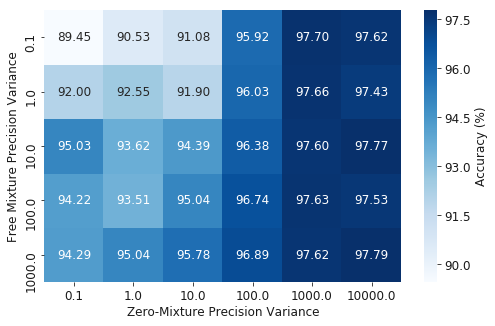

In [287]:
plt.figure(figsize=(8,5))
sns.heatmap(exp.pivot(index='var', columns='zvar', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Variance")
plt.ylabel("Free Mixture Precision Variance")
plt.savefig('figs/swsvaracc.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

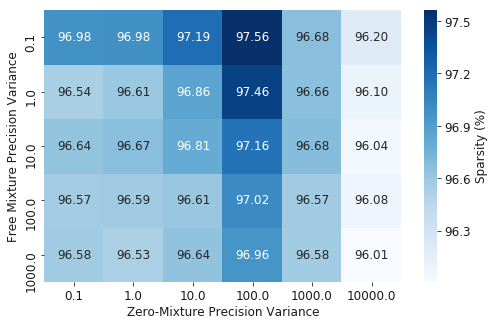

In [288]:
plt.figure(figsize=(8,5))
sns.heatmap(exp.pivot(index='var', columns='zvar', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Variance")
plt.ylabel("Free Mixture Precision Variance")
plt.savefig('figs/swsvarsp.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### 3. Means on Gamma Priors

In [289]:
m_exp = pd.DataFrame(columns = ["mean", "zmean", "acc", "sp"])
idx=0
#start from 10, 1000
for mean in [0.1, 1, 10, 100, 1000]:#, 10000
    for zmean in [0.1, 1, 10, 100, 1000, 10000]:
        res = loadfile(mean, 0.1, zmean, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files")
        m_exp.loc[idx] = ([mean, zmean, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

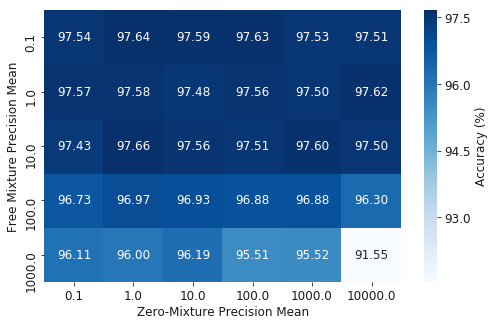

In [290]:
plt.figure(figsize=(8,5))
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Mean")
plt.ylabel("Free Mixture Precision Mean")
plt.savefig('figs/swsmeanacc.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

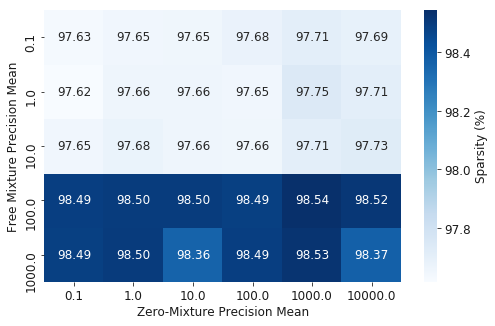

In [291]:
 
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Mean")
plt.ylabel("Free Mixture Precision Mean")
plt.savefig('figs/swsmeansp.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### 4. Mixtures

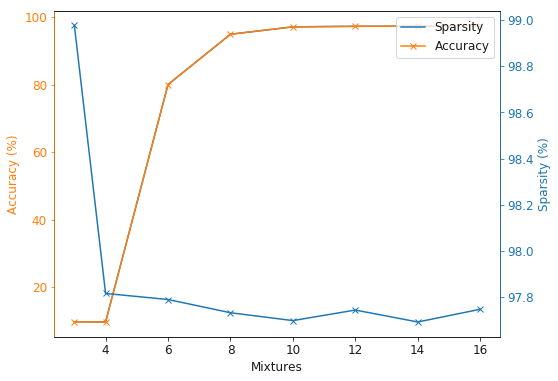

In [593]:
mix_exp = pd.DataFrame(columns = ["mixture", "acc", "sp"])
idx=0
#start from 10, 1000
mixlist = [3, 4, 6, 8, 10, 12, 14, 16]
#mixlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]
for mix in mixlist:
    res = loadfile(1, 0.1, 1000, 1000, 1e-6, int(0), mix, "LeNet_300_100", model_save_dir = "./files")
    mix_exp.loc[idx] = ([mix, res["prune_acc"]["test"], res["sparsity"]])
    idx+=1
    
fig, ax1 = plt.subplots(figsize=(8,6))

ax2 = ax1.twinx()
p2 = ax1.plot(mix_exp['mixture'], mix_exp['acc'], label = "Sparsity")
p1 = ax1.plot(mix_exp['mixture'], mix_exp['acc'], label = "Accuracy",  marker = 'x')
p1c = p1[0].get_color()
p2c = p2[0].get_color()
ax1.legend(loc=1)
p2 = ax2.plot(mix_exp['mixture'], mix_exp['sp'], color = p2c,  marker = 'x')

ax1.set_xlabel('Mixtures')
ax1.set_ylabel('Accuracy (%)', color=p1c)
ax2.set_ylabel('Sparsity (%)', color=p2c)
ax2.spines['left'].set_color(p1c)
ax2.spines['right'].set_color(p2c)
ax1.tick_params(axis='y', colors=p1c)
ax2.tick_params(axis='y', colors=p2c)
plt.savefig('figs/swsmix.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### 5. Tau

In [618]:
tau_exp = pd.DataFrame(columns = ["tau", "acc", "sp"])
taulist = [5e-8, 1e-7, 2e-7, 5e-7, 8e-7, 1e-6, 2e-6,5e-6, 8e-6, 1e-5, 2e-5]#[5e-8, 2e-8, 1e-8, 8e-7, 8e-6, 5e-5]
for tau in taulist:
    res = loadfile(1, 0.1, 1000, 1000, tau, int(0), 16, "LeNet_300_100", model_save_dir = "./files")
    tau_exp.loc[idx] = ([tau, res["prune_acc"]["test"], res["sparsity"]])
    idx+=1

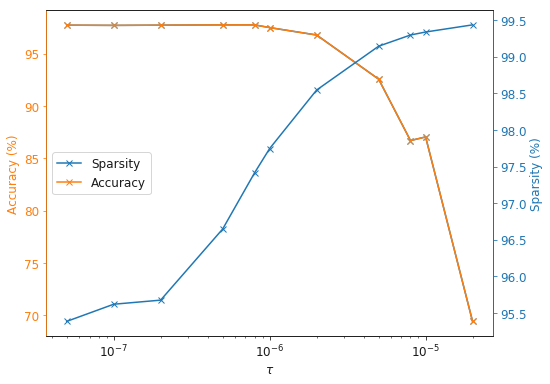

In [630]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.semilogx()
ax2 = ax1.twinx()

p2 = ax1.plot(tau_exp['tau'], tau_exp['acc'], label = "Sparsity", marker = 'x')
p1 = ax1.plot(tau_exp['tau'], tau_exp['acc'], label = "Accuracy",  marker = 'x')
p1c = p1[0].get_color()
p2c = p2[0].get_color()
ax1.legend(loc=6)
p2 = ax2.plot(tau_exp['tau'], tau_exp['sp'], color = p2c,  marker = 'x')

ax1.set_xlabel('$\\tau$')
ax1.set_ylabel('Accuracy (%)', color=p1c)
ax2.set_ylabel('Sparsity (%)', color=p2c)
ax2.spines['left'].set_color(p1c)
ax2.spines['right'].set_color(p2c)
ax1.tick_params(axis='y', colors=p1c)
ax2.tick_params(axis='y', colors=p2c)
plt.savefig('figs/swstau.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### 6. Different Data

In [640]:
lnm = loadfile(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files", dset="mnist")
lnfm = loadfile(250, 10, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files", dset="fashionmnist")
smm = loadfile(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "SWSModel", model_save_dir = "./files", dset="mnist")
smfm = loadfile(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "SWSModel", model_save_dir = "./files", dset="fashionmnist")

In [666]:
def layer_stats(res):
    lt_print = ""
    for layer in res['prune_weights']:
        z = (res['prune_weights'][layer] == 0).sum()
        t = res['prune_weights'][layer].size
        print ("{}: Sparsity: {:.2f}, w!=0: {}".format(layer, z/t * 100, t-z))
        lt_print += "& {} & {:.2f} & {} \\\\ \n".format(t, z/t*100, t-z)
    model = stack_weights(res['prune_weights'])
    model_z = (model == 0).sum()
    model_t = model.size
    print ('Model Sparsity: {:.2f}, w!=0: {}'.format(res['sparsity'], model_t - model_z))
    print ('Final Accuracy : {:.2f}'.format(res['prune_acc']['test']))
    lt_print += "& {} & {:.2f} & {} \\\\".format(model_t, model_z/model_t*100, model_t-model_z)
    print (lt_print)
layer_stats(smm)

conv1: Sparsity: 49.54, w!=0: 328
conv2: Sparsity: 88.65, w!=0: 1283
fc1: Sparsity: 99.50, w!=0: 3144
fc2: Sparsity: 86.69, w!=0: 667
Model Sparsity: 99.16, w!=0: 5422
Final Accuracy : 98.21
& 650 & 49.54 & 328 \\ 
& 11300 & 88.65 & 1283 \\ 
& 625500 & 99.50 & 3144 \\ 
& 5010 & 86.69 & 667 \\ 
& 642460 & 99.16 & 5422 \\


In [683]:
print_fin(smfm)

88.45 & 97.95 & 150.6


In [678]:
def print_fin(res):
    print("{:.2f} & {:.2f} & {:.1f}".format(res['prune_acc']['test'], res['sparsity'], cr_calc(res)[6]['cr']))

In [ ]:
512 + 55584 + 36340

In [701]:
def get_proportions(crdict):
    total = crdict['wb'] + crdict['ib'] + crdict['sb'] + crdict['cb']
    print ("Codebook: {:.1f}".format(100*(crdict['sb'] + crdict['cb'])/total))
    print ("Index: {:.1f}".format(100*crdict['ib']/total))
    print ("Weights: {:.1f}".format(100*crdict['wb']/total))
    
get_proportions(cr_calc(lnm)[6])

Codebook: 0.6
Index: 60.1
Weights: 39.3


### 7. CR Calc

In [696]:
import numpy as np
import pickle

def loadfile(mean, var, zmean, zvar, tau, temp, mixtures, model, data_size = "full",  scaling = False, model_save_dir = "", fn="", file = "res", dset="mnist"):
    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model, mean, zmean, 50, tau, int(mixtures), int(temp), s, data_size) + fn
    if (file=='res'):
        with open(model_save_dir + '/{}_retrain_res_{}.p'.format(dset, exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='gmp'):
        with open(model_save_dir + '/{}_retrain_gmp_{}.p'.format(dset, exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='model'):
        file = torch.load(model_save_dir + '/{}_retrain_model_{}.m'.format(dset, exp_name))
    return file

def stack_weights(weight_dict):
    weights = np.array([], dtype=np.float32)
    for layer in weight_dict:
        weights = np.hstack( (weights, weight_dict[layer] ) )
    return weights

#Codebook
#Create Indexbook
def create_index(bpi, nz_list):
    max_skip = 2**bpi
    if (nz_list[0] != 0):
        ridx_list = [0]
        w_list = [0]
    else:
        ridx_list = []
        w_list = []

    cidx = 0
    for nz in nz_list:

        nzc = nz - cidx
        ins_0 = int(np.floor(nzc/max_skip))
        nidx = int(nzc - (max_skip * ins_0))
        for i in range (ins_0):
            w_list.append(0)
            ridx_list.append(max_skip)
        w_list.append(1)
        ridx_list.append(nidx)
        #print (nz, cidx, nzc)
        cidx = nz
    lri = len(weight_p) - sum(ridx_list)
    if (lri>0):
        ridx_list.append(lri-1)
        w_list.append(0)
    return ridx_list, w_list

def recover_index(ridx_list, w_list, sz):
    rec = np.zeros(sz)
    for r,w in zip (list(np.array(ridx_list).cumsum()), w_list):
        rec[r] = w
    return rec

def cr_calc(res):
    mixtures = res['mixtures']
    weight_p = stack_weights(res['prune_weights'])
    weight_s = (weight_p != 0)
    nz_list = list(np.where(weight_s == True)[0])
    cb = 32.0 * mixtures
    sb = 32.0 * (len(res['scale'][-1]) - 1)
    orig_net = len(weight_p) * 32.0
    
    res_dict = {}
    
    for bpi in range(2,10):
        rl, wl = create_index (bpi, nz_list)
        #rec = recover_index(rl, wl, len(weight_p))
        ib = bpi * len(ridx_list)
        bpw = np.ceil(np.log2(res['mixtures']))
        wb = bpw * len(wl)
        cr = orig_net / (cb + wb + ib + sb)
        res2_dict = {}
        res2_dict['cr'] = cr
        res2_dict['on'] = orig_net
        res2_dict['wb'] = wb
        res2_dict['ib'] = ib
        res2_dict['sb'] = sb
        res2_dict['cb'] = cb
        res_dict[bpi] = res2_dict
    return res_dict